In [1]:
#load dataset
import pandas as pd
import matplotlib.pyplot as pl

import nltk

DATASET_COLUMNS = ["target", "id", "time", "query", "to", "posts"]
data=pd.read_csv('data.csv', names=DATASET_COLUMNS , encoding='ISO-8859-1')
data.head()

,target,id,time,query,to,posts
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [2]:
#Dataset Analysis
print(data["query"].unique())
data['target'].unique()
data.dtypes
data['target'] = data['target'].replace(4,1)
data['target'].unique()
#data['target'].nunique()

['NO_QUERY']


array([0, 1], dtype=int64)

In [3]:
# grouping data according to target
target_grouped =  data.groupby('target')['target'].count
target_grouped


<bound method SeriesGroupBy.count of <pandas.core.groupby.generic.SeriesGroupBy object at 0x1C5891F0>>

In [4]:
#splitting data to lists
target_list = list(data['target'])
text_list = list(data['posts'])
target_list
text_list

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing ",
 'I just re-pierced my ears ',
 "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
 '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ',
 "@smarrison i wo

<AxesSubplot:xlabel='target', ylabel='count'>

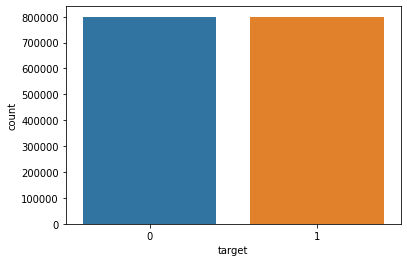

In [5]:
#visualizing data distribution according to target
import seaborn as sns
sns.countplot(x='target', data=data)

In [6]:
# spliting positive and negative data
data_pos=data[data['target']==1]
data_pos
data_neg=data[data['target']==0]

In [7]:
#reducing data size to 25%
data_pos=data_pos.iloc[:int(200000)]
data_neg=data_neg.iloc[:int(200000)]

In [8]:
# removing url
import re
pattern_url = '((www.[^s]+)|(https?://[^s]+))'
def remove_pattern(text, pattern):
    return re.sub(pattern, ' ', text)

data['posts'] = data['posts'].apply(lambda x: remove_pattern(x, pattern_url))

In [9]:
# removing punctuations except @
import string
english_punctuations = string.punctuation
english_punctuations = english_punctuations.replace("@", "")
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['posts']= data['posts'].apply(lambda x: cleaning_punctuations(x))
data['posts'].head()


0    @switchfoot  s a bummer  You shoulda got David...
1    is upset that he cant update his Facebook by t...
2    @Kenichan I dived many times for the ball Mana...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no its not behaving at all im...
Name: posts, dtype: object

In [10]:
# removing username
import re
pattern = '@\S+'
def remove_pattern(text, pattern):
    r = re.findall(pattern,text)
    for i in r:
        text = re.sub(i,"",text)
    return text

data['posts'] = data['posts'].apply(lambda x: remove_pattern(x, pattern))
data['posts']

0            s a bummer  You shoulda got David Carr of Th...
1          is upset that he cant update his Facebook by t...
2           I dived many times for the ball Managed to sa...
3            my whole body feels itchy and like its on fire 
4           no its not behaving at all im mad why am i he...
                                 ...                        
1599995    Just woke up Having no school is the best feel...
1599996    TheWDBcom  Very cool to hear old Walt intervie...
1599997    Are you ready for your MoJo Makeover Ask me fo...
1599998    Happy 38th Birthday to my boo of alll time Tup...
1599999                             happy charitytuesday    
Name: posts, Length: 1600000, dtype: object

In [11]:
#removing numbers
pattern_num = '[0-9]+'
data['posts'] = data['posts'].apply(lambda x: remove_pattern(x, pattern_num))
data['posts'][92566]

' essay down  to go  ughh kill me now'

In [12]:
data['posts'] = data['posts'].str.lower()
data['posts']

0            s a bummer  you shoulda got david carr of th...
1          is upset that he cant update his facebook by t...
2           i dived many times for the ball managed to sa...
3            my whole body feels itchy and like its on fire 
4           no its not behaving at all im mad why am i he...
                                 ...                        
1599995    just woke up having no school is the best feel...
1599996    thewdbcom  very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy th birthday to my boo of alll time tupac...
1599999                             happy charitytuesday    
Name: posts, Length: 1600000, dtype: object

In [13]:
nltk.download('punkt')
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


def clean_stop(text) :
    return " ".join([x for x in str(text).split() if x not in stopwordlist])

data['posts'] = data['posts'].apply(lambda x : clean_stop(x))
data['posts']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0                    bummer shoulda got david carr third day
1          upset cant update facebook texting might cry r...
2          dived many times ball managed save rest go bounds
3                           whole body feels itchy like fire
4                       no not behaving im mad cant see over
                                 ...                        
1599995                     woke no school best feeling ever
1599996          thewdbcom cool hear old walt interviews â«
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999                                 happy charitytuesday
Name: posts, Length: 1600000, dtype: object

In [14]:
# tokenization

from nltk.tokenize import RegexpTokenizer
data['posts'] = data['posts'].apply(nltk.word_tokenize)
data['posts']

0            [bummer, shoulda, got, david, carr, third, day]
1          [upset, cant, update, facebook, texting, might...
2          [dived, many, times, ball, managed, save, rest...
3                    [whole, body, feels, itchy, like, fire]
4              [no, not, behaving, im, mad, cant, see, over]
                                 ...                        
1599995              [woke, no, school, best, feeling, ever]
1599996    [thewdbcom, cool, hear, old, walt, interviews,...
1599997                [ready, mojo, makeover, ask, details]
1599998    [happy, th, birthday, boo, alll, time, tupac, ...
1599999                              [happy, charitytuesday]
Name: posts, Length: 1600000, dtype: object

In [15]:

st = nltk.PorterStemmer()
def stemming_on_text(data):
    data = [st.stem(word) for word in data]
    return data
data['posts'] = data['posts'].apply(lambda x: stemming_on_text(x))
data['posts']




0            [bummer, shoulda, got, david, carr, third, day]
1          [upset, cant, updat, facebook, text, might, cr...
2          [dive, mani, time, ball, manag, save, rest, go...
3                     [whole, bodi, feel, itchi, like, fire]
4                 [no, not, behav, im, mad, cant, see, over]
                                 ...                        
1599995                 [woke, no, school, best, feel, ever]
1599996    [thewdbcom, cool, hear, old, walt, interview, ...
1599997                   [readi, mojo, makeov, ask, detail]
1599998    [happi, th, birthday, boo, alll, time, tupac, ...
1599999                              [happi, charitytuesday]
Name: posts, Length: 1600000, dtype: object

In [16]:
nltk.download('omw-1.4')
nltk.download('wordnet')
lt = nltk.WordNetLemmatizer()
def lemmatizing_on_text(data):
    data = [lt.lemmatize(word) for word in data]
    return data
data['posts']= data['posts'].apply(lambda x: lemmatizing_on_text(x))
data['posts']

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


0            [bummer, shoulda, got, david, carr, third, day]
1          [upset, cant, updat, facebook, text, might, cr...
2          [dive, mani, time, ball, manag, save, rest, go...
3                     [whole, bodi, feel, itchi, like, fire]
4                 [no, not, behav, im, mad, cant, see, over]
                                 ...                        
1599995                 [woke, no, school, best, feel, ever]
1599996    [thewdbcom, cool, hear, old, walt, interview, ...
1599997                   [readi, mojo, makeov, ask, detail]
1599998    [happi, th, birthday, boo, alll, time, tupac, ...
1599999                              [happi, charitytuesday]
Name: posts, Length: 1600000, dtype: object

In [17]:
x = data.posts
y = data.target

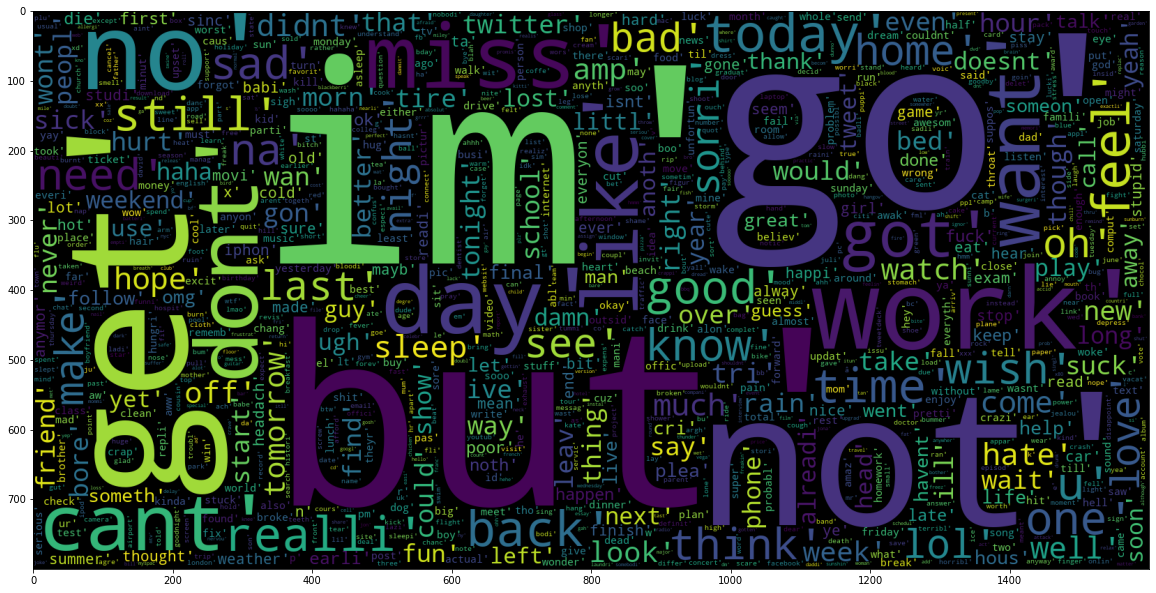

In [27]:

from wordcloud import WordCloud 
import matplotlib as plt
data_neg = data['posts'][800000:]
pl.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(str(word) for word in data_neg))
pl.imshow(wc)

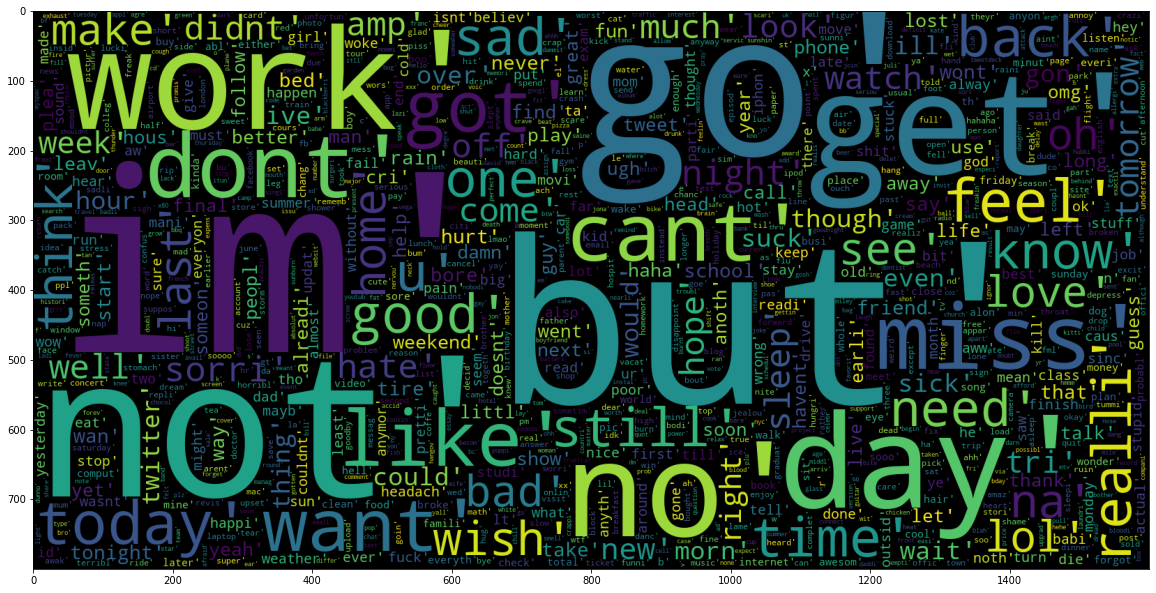

In [30]:
data_pos = data['posts'][:800000]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(str(word) for word in data_pos))
pl.figure(figsize = (20,20))
pl.imshow(wc)

In [ ]:
# def remove_duplicate(text) :
#     return re.sub(r'(.)1+', r'1', text)
# data['posts'] = data['posts'].apply(lambda x : remove_duplicate(x))
# data['posts'][1048569]

# jatin = "jattin is a a sad sad"
# jatin=remove_duplicate(jatin)
# jatin

In [ ]:
# st = nltk.PorterStemmer()
# def stemming_on_text(text):
#     return " ".join([st.stem(x) for x in str(text).split()])

# data['posts'] = data['posts'].apply(lambda x : stemming_on_text(x))
# data['posts']

In [ ]:
# display(data.to_string())
# data['posts'][3]

In [ ]:
# # remove punctuations
# import string
# import re
# punctuation = string.punctuation
# punctuation = punctuation.replace("@", "")
# punctuation_list = list(punctuation)

# """
# def remove_punctuation(text) :
#     for i in punctuation_list :
#         if (text.find(i)!=-1) :
#             text.replace(i, " ")
#     return text
# """

# def remove_punct(text):
#     new_words = []
#     for word in text:
#         w = re.sub(r'[^\w\s\@]','',word) #remove everything except words and space
#         w = re.sub(r'_','',w) #how to remove underscore as well
#         new_words.append(w)
#     return ''.join(str(e) for e in new_words)
    

# data['posts'] = data['posts'].apply(lambda x : remove_punct(x))
# data['posts']
# new_data = data['posts']

# #data['posts'] = data['posts'].str.replace("[^@a-zA-Z#]", " ")
# #data['posts']


In [ ]:
#print(data['posts'][0])

#for i in range(80000,800000) :
#    data['posts'][i]=remove_pattern(data['posts'][i], pattern)